In [ ]:
!pip install einops matplotlib

In [186]:
!git commit -am "added draft grid masking"; git push

[sliding_tiling 706b5b1] added draft grid masking
 1 file changed, 48 insertions(+), 9 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 20 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 1.67 KiB | 1.67 MiB/s, done.
Total 3 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:dmarx/notebooks.git
   2b8aa57..706b5b1  sliding_tiling -> sliding_tiling


In [187]:
from copy import deepcopy
import os
import io
import warnings
from PIL import Image
from stability_sdk import client
import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

import torch
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import linear_sum_assignment
from einops import rearrange

import numpy as np
from IPython.display import display


def multiplex(latents, K):
    """
    Rearrange the latents tensor into a KxK grid using the einops rearrange function.

    Parameters
    ----------
    latents: torch.Tensor
        The latent tensors to be rearranged.
    K: int
        The grid size for rearrangement.

    Returns
    -------
    torch.Tensor
        The rearranged latents in a KxK grid.
    """
    return rearrange(latents, '(b k1 k2) h w c -> b (k1 h) (k2 w) c', k1=K, k2=K)


def demultiplex(images, K):
    """
    Rearrange the images tensor back from a KxK grid using the einops rearrange function.

    Parameters
    ----------
    images: torch.Tensor
        The image tensors to be rearranged.
    K: int
        The grid size for rearrangement.

    Returns
    -------
    torch.Tensor
        The rearranged images from a KxK grid back to their original shape.
    """
    return rearrange(images, ' (k1 h) (k2 w) c -> (k1 k2) h w c', k1=K, k2=K)


def generate_image(**kargs):
    # Set up our initial generation parameters.
    answers = stability_api.generate(
        **kargs
    )

    # Set up our warning to print to the console if the adult content classifier is tripped.
    # If adult content classifier is not tripped, save generated images.
    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn(
                    "Your request activated the API's safety filters and could not be processed."
                    "Please modify the prompt and try again.")
            if artifact.type == generation.ARTIFACT_IMAGE:
                img = Image.open(io.BytesIO(artifact.binary))
                #img.save(str(artifact.seed)+ ".png") # Save our generated images with their seed number as the filename.
                return img

            
def upscale_image(**kargs):
    # Set up our initial generation parameters.
    answers = stability_api.upscale(
        **kargs
    )

    # Set up our warning to print to the console if the adult content classifier is tripped.
    # If adult content classifier is not tripped, save generated images.
    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn(
                    "Your request activated the API's safety filters and could not be processed."
                    "Please modify the prompt and try again.")
            if artifact.type == generation.ARTIFACT_IMAGE:
                img = Image.open(io.BytesIO(artifact.binary))
                #img.save(str(artifact.seed)+ ".png") # Save our generated images with their seed number as the filename.
                return img

            
def image_to_grid(img, k=4, downsample=True):
    if downsample:
        h,w = img.size
        img = img.resize((h//k,w//k))
    imlist =[np.array(img)]*(k**2)
    gridded = multiplex(imlist, K=k)
    image_grid = Image.fromarray(np.squeeze(gridded.astype(np.uint8)))
    return image_grid


In [115]:
# Set up our connection to the API.
stability_api = client.StabilityInference(
    key=os.environ['STABILITY_KEY'], # API Key reference.
    verbose=True, # Print debug messages.
    engine="stable-diffusion-v1-5", # Set the engine to use for generation.
    # Available engines: stable-diffusion-v1 stable-diffusion-v1-5 stable-diffusion-512-v2-0 stable-diffusion-768-v2-0
    # stable-diffusion-512-v2-1 stable-diffusion-768-v2-1 stable-diffusion-xl-beta-v2-2-2 stable-inpainting-v1-0 stable-inpainting-512-v2-0
    upscale_engine="stable-diffusion-x4-latent-upscaler",
)

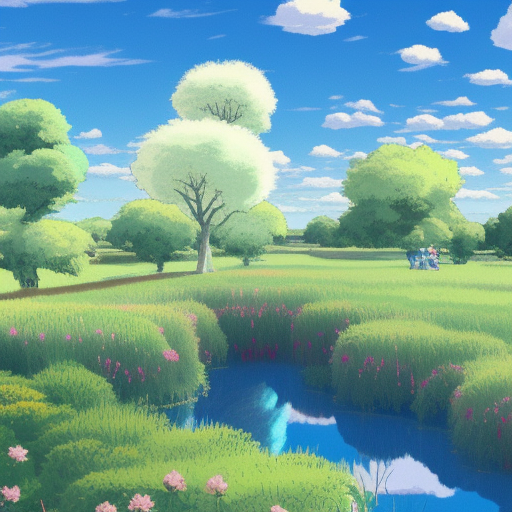

In [154]:
img = generate_image(
    prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    seed=992446758, # If a seed is provided, the resulting generated image will be deterministic.
                    # What this means is that as long as all generation parameters remain the same, you can always recall the same image simply by generating it again.
                    # Note: This isn't quite the case for CLIP Guided generations, which we tackle in the CLIP Guidance documentation.
    steps=30, # Amount of inference steps performed on image generation. Defaults to 30.
    cfg_scale=8.0, # Influences how strongly your generation is guided to match your prompt.
                   # Setting this value higher increases the strength in which it tries to match your prompt.
                   # Defaults to 7.0 if not specified.
    width=512, # Generation width, defaults to 512 if not included.
    height=512, # Generation height, defaults to 512 if not included.
    samples=1, # Number of images to generate, defaults to 1 if not included.
    sampler=generation.SAMPLER_K_DPMPP_2M # Choose which sampler we want to denoise our generation with.
                                                 # Defaults to k_dpmpp_2m if not specified. Clip Guidance only supports ancestral samplers.
                                                 # (Available Samplers: ddim, plms, k_euler, k_euler_ancestral, k_heun, k_dpm_2, k_dpm_2_ancestral, k_dpmpp_2s_ancestral, k_lms, k_dpmpp_2m, k_dpmpp_sde)
)

img

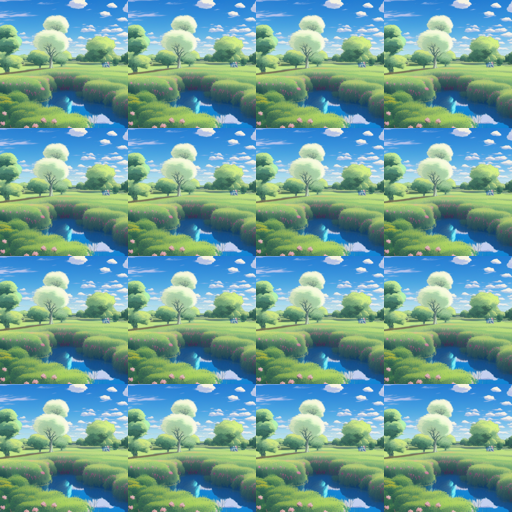

In [153]:
image_grid = image_to_grid(img)
image_grid

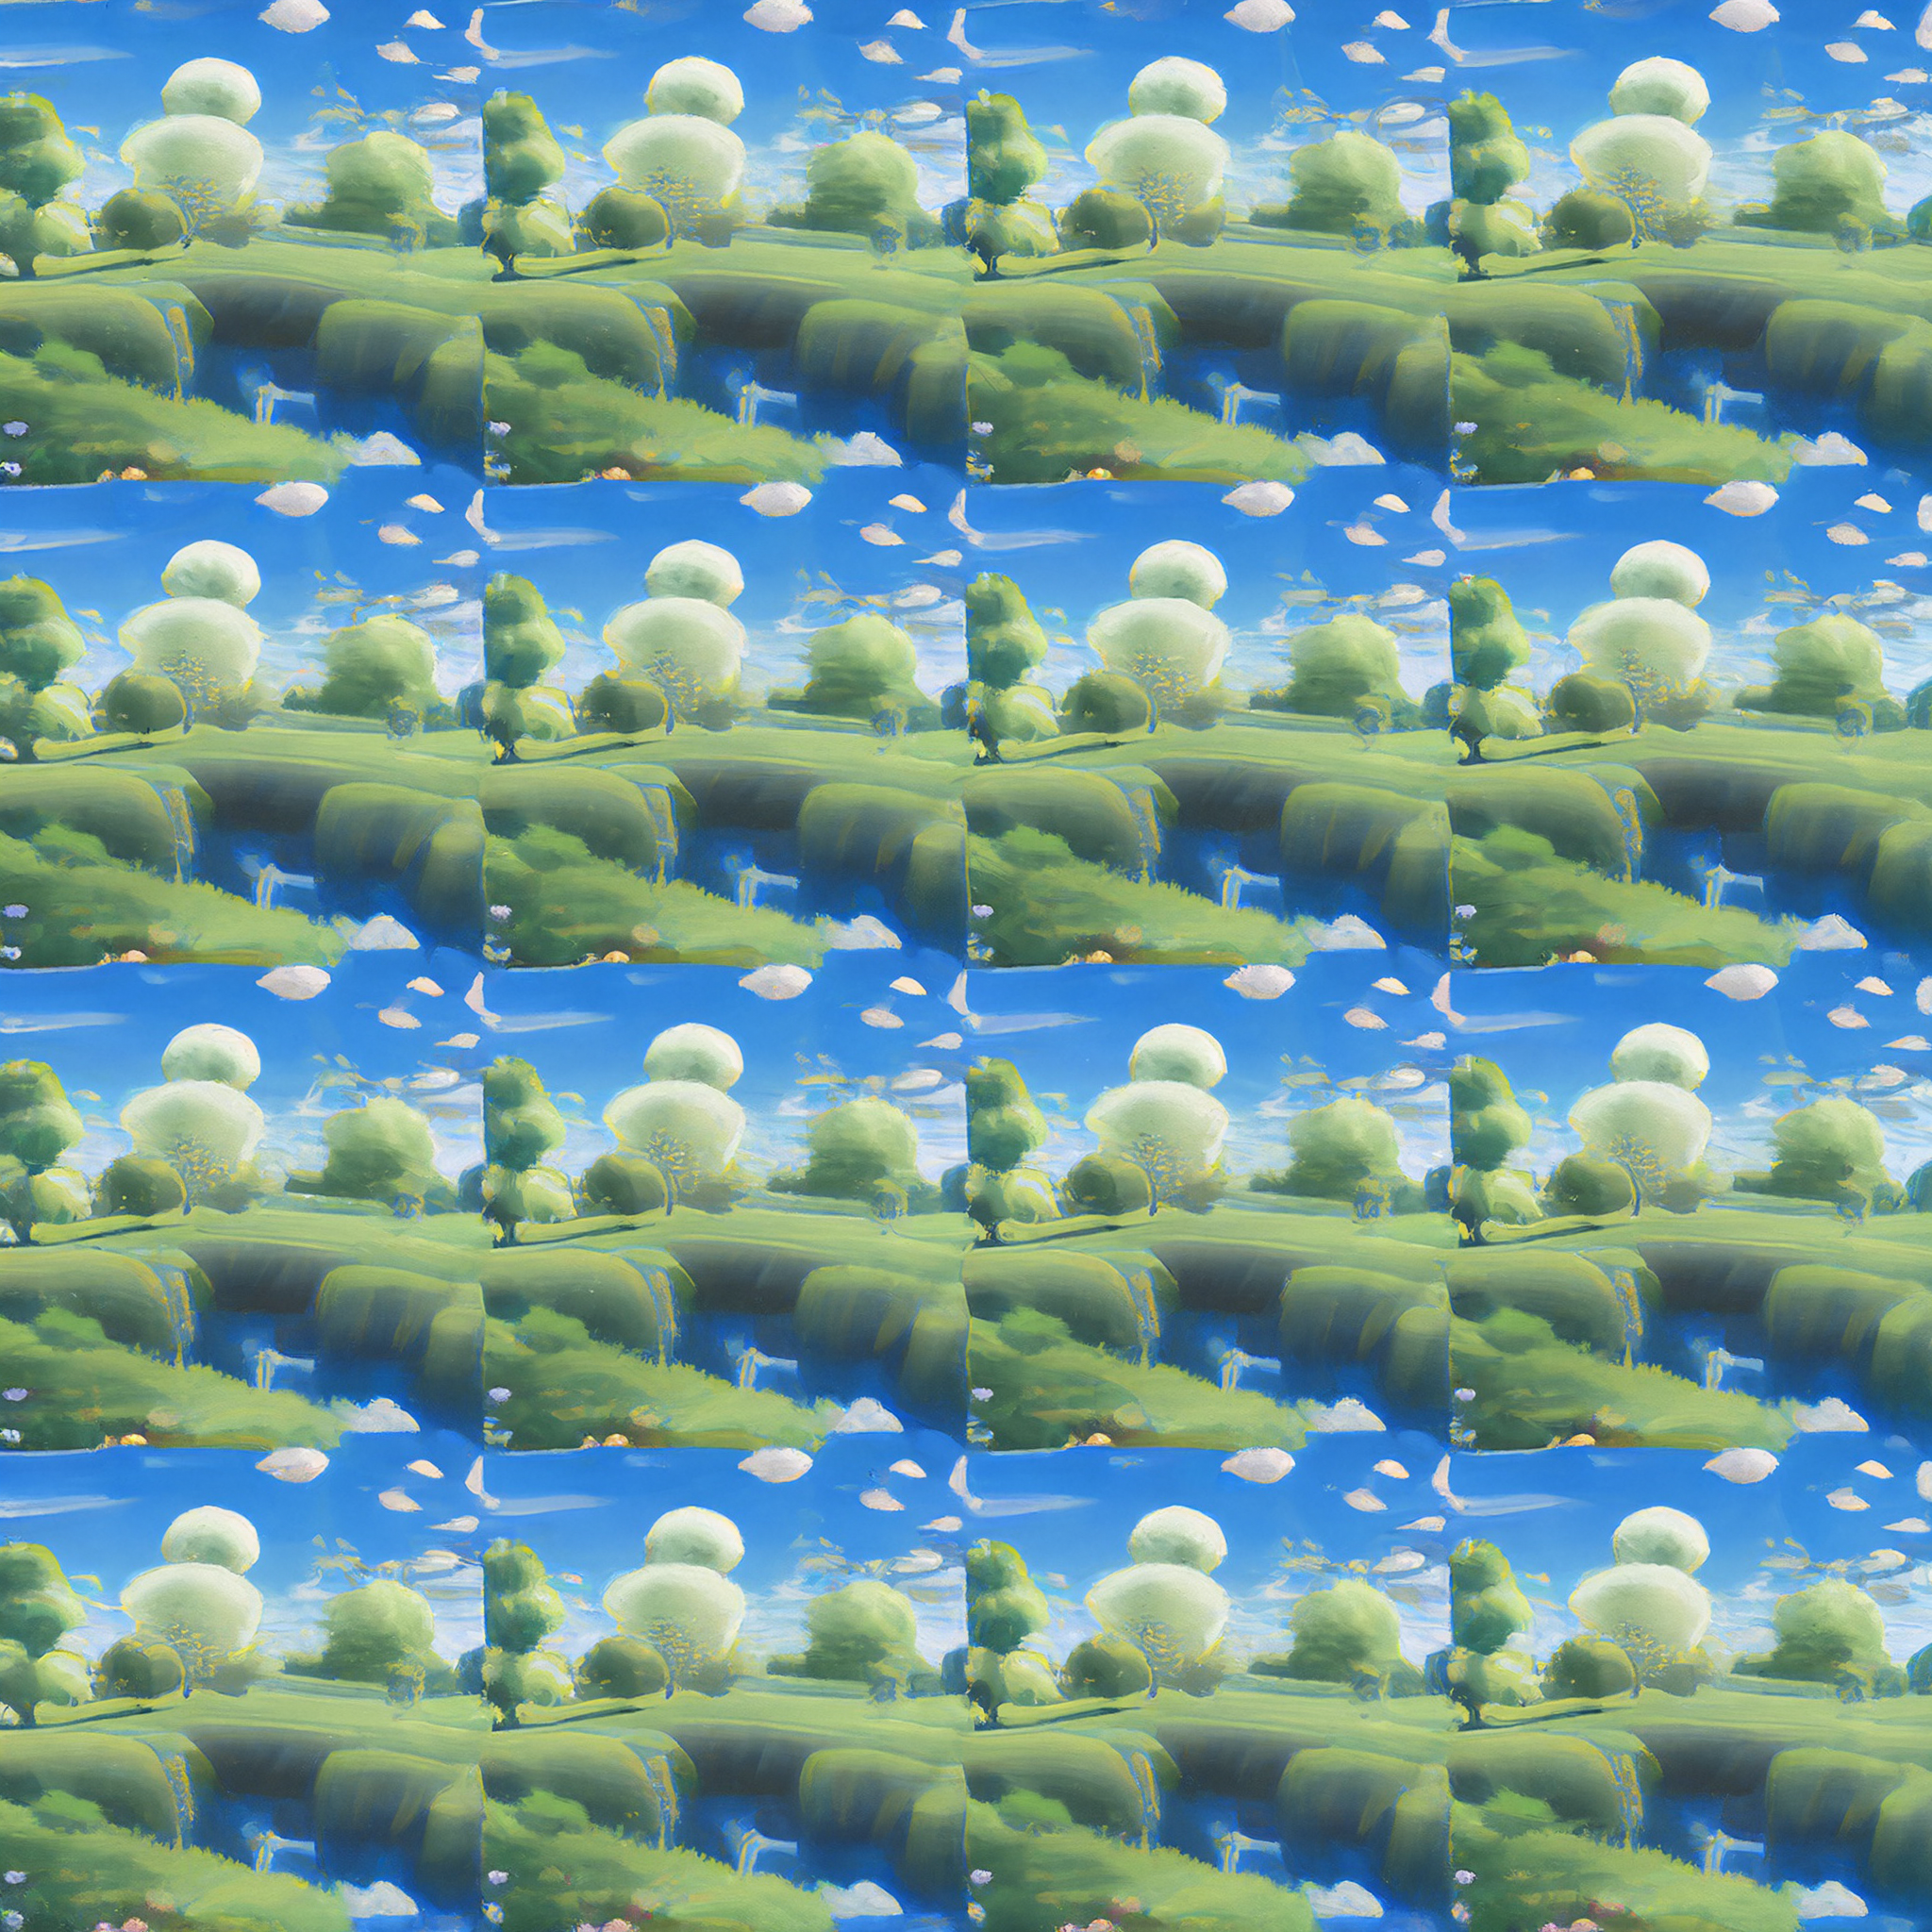

In [126]:
seed=12345678

# apply diffusion step to image grid
image_grid2 = generate_image(
    init_image = image_grid,
    start_schedule=0.2,
    #########################
    prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    steps=30,
    cfg_scale=8.0,
    width=512,
    height=512,
    samples=1,
    seed=seed,
    sampler=generation.SAMPLER_K_DPMPP_2M
)

# upscale generation
image_grid3 = upscale_image(
    init_image = image_grid2,
    #start_schedule=0.2,
    #########################
    prompt="expansive landscape rolling greens with blue daisies and weeping willow trees under a blue alien sky, artstation, masterful, ghibli",
    steps=30,
    cfg_scale=8.0,
    width=512*4,
    #height=512,
    #samples=1,
    seed=seed,
    #sampler=generation.SAMPLER_K_DPMPP_2M
)

image_grid3

In [174]:

imlist3 = demultiplex(np.array(image_grid3), K=4)

#imlist3.shape # (16, 512, 512, 3)

im_vectors = rearrange(imlist3, "b h w c -> b (h w c)")

#im_vectors.shape # (16, 786432)

dmat = pdist(im_vectors, metric='cosine')
dmat.shape # 120
dmat2 = squareform(dmat)
dmat2.shape # 16 16

distance_matrix = dmat2[:]
np.fill_diagonal(distance_matrix, 1)


num_fixed=0

row_indices, col_indices = linear_sum_assignment(distance_matrix[num_fixed:, num_fixed:])

# Add the fixed indices back to get the final sorted order
sorted_order = torch.cat([torch.arange(num_fixed), torch.as_tensor(col_indices + num_fixed)])

images = imlist3[sorted_order] # images.shape


In [175]:
images.shape

(16, 512, 512, 3)

In [176]:
images = [Image.fromarray(v) for v in images]    

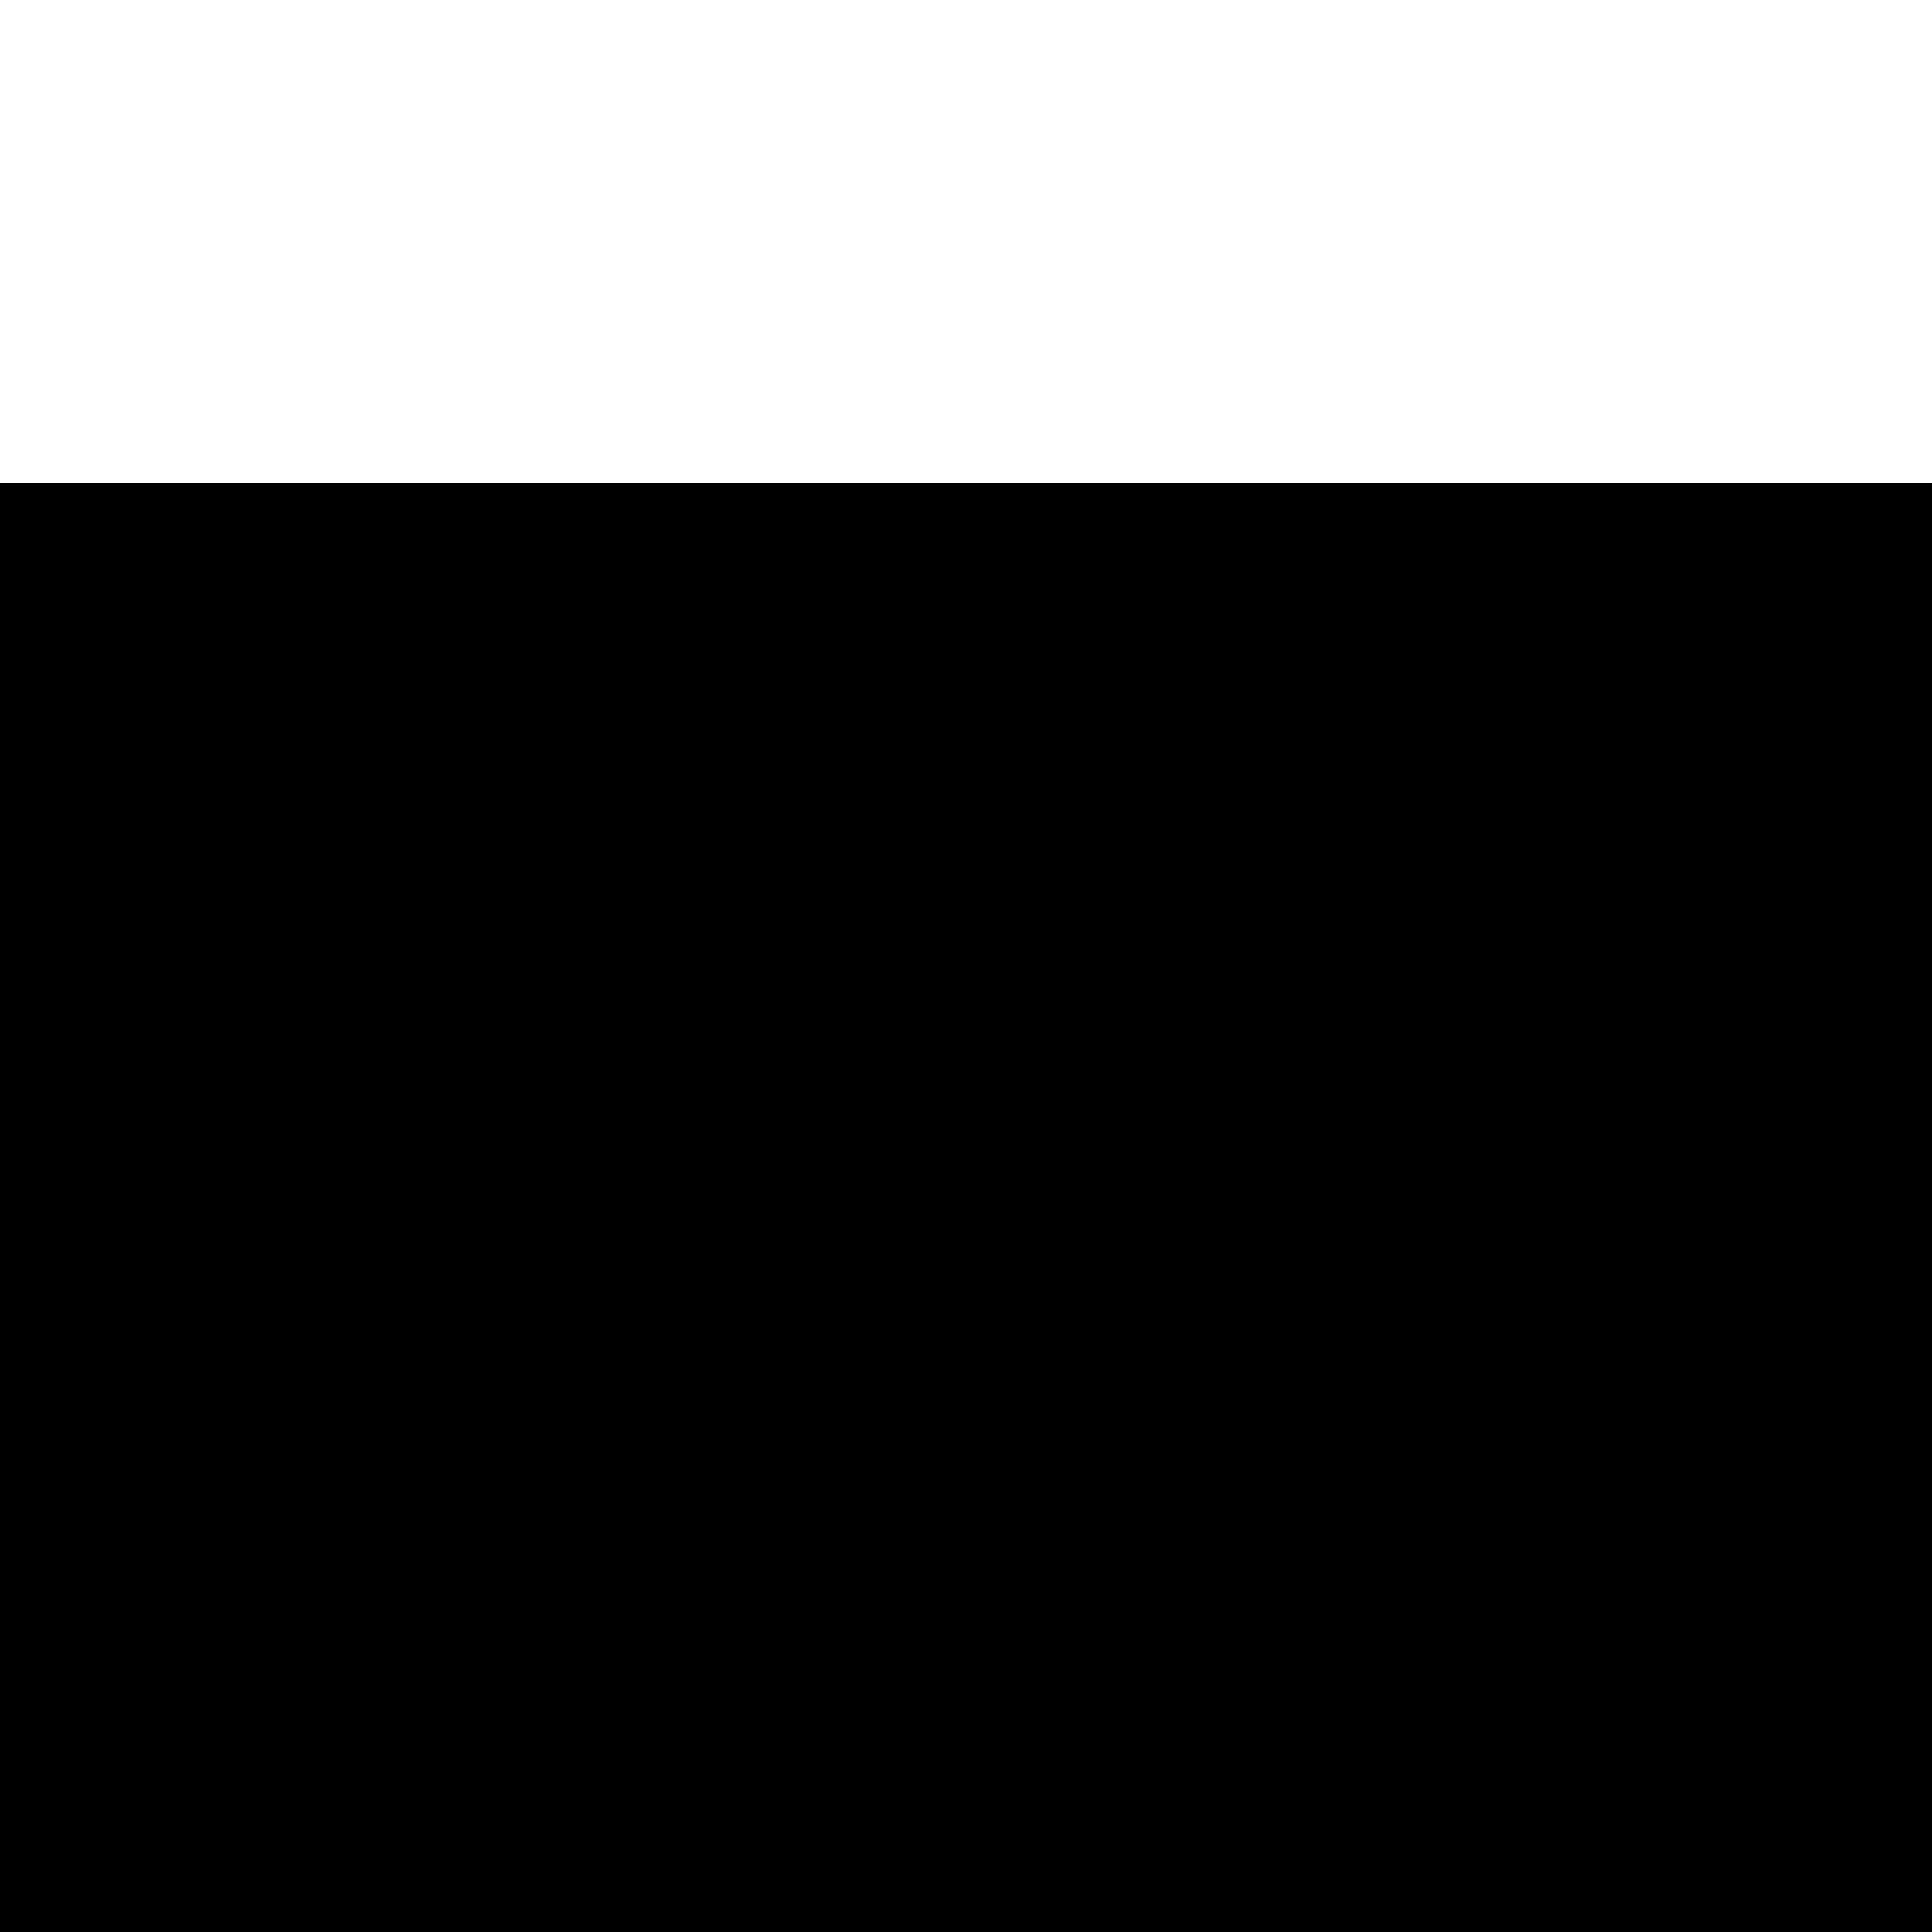

In [188]:
from itertools import chain

def partition_grid(images, n_frozen=None):
    """
    Partition the grid of images into frozen and dynamic partitions.

    Parameters
    ----------
    images: list
        List of images in the grid.
    n_frozen: int or None, optional (default=None)
        Number of images to keep fixed as frozen. If None, defaults to the square root of the total number of images.

    Returns
    -------
    PIL.Image.Image, list
        The mask image representing the frozen partition and the list of images in the dynamic partition.
    """
    K = int(np.sqrt(len(images)))

    if n_frozen is None:
        n_frozen = K

    frozen_partition = []
    mask_images = []

    for i, im in enumerate(images):
        if i < n_frozen:
            mask = np.ones_like(im) * 255
            frozen_partition.append(im)
        else:
            mask = np.zeros_like(im)
        mask_images.append(mask)

    mask_image = multiplex(mask_images, K)
    mask_image = Image.fromarray(np.squeeze(mask_image))

    return mask_image, frozen_partition

mask, dynamic_partition = partition_grid(images)

#mask

In [ ]:

for im in images:
    display(im)

---